In [1]:
# -*- coding: utf-8 -*-
import os
import gc
import argparse
import json
import random
import math
import random
from functools import reduce
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, classification_report
import torch
from torch import nn
from torch.optim import Adam, SGD, AdamW
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts, CyclicLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
from tqdm import tqdm

from performer_pytorch import PerformerLM
import scanpy as sc
import anndata as ad
from utils import *
from datetime import datetime
from time import time
import torch.multiprocessing as mp
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
from torch.utils.tensorboard import SummaryWriter

from sklearn.linear_model import LogisticRegression
import seaborn as sns

### preprocess MacParland data

In [2]:
# transpose data from the way it was downloaded from GEO
data_df = pd.read_csv('/data/rna_rep_learning/scBERT/macparland/GSE115469_Data.csv', index_col=0)
data_df.transpose().to_csv('/data/rna_rep_learning/scBERT/macparland/GSE115469_Data_transposed.csv')

In [3]:
panglao = sc.read_h5ad('/data/rna_rep_learning/scBERT/panglao_10000.h5ad')
data = sc.read_csv('/data/rna_rep_learning/scBERT/macparland/GSE115469_Data_transposed.csv')
counts = sparse.lil_matrix((data.X.shape[0],panglao.X.shape[1]),dtype=np.float32)

/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
# data already is log-normalized
print(data.X.min())
print(data.X.max())

0.0
21.731197


In [11]:
ref = panglao.var_names.tolist()
obj = data.var_names.tolist()

for i in range(len(ref)):
    if ref[i] in obj:
        loc = obj.index(ref[i])
        counts[:,i] = data.X[:,loc]

counts = counts.tocsr()
new = ad.AnnData(X=counts)
new.var_names = ref
new.obs_names = data.obs_names
new.obs = data.obs
new.uns = panglao.uns

sc.pp.filter_cells(new, min_genes=200)
#this dataset seems to already be log-normalized
#sc.pp.normalize_total(new, target_sum=1e4)
#sc.pp.log1p(new, base=2)
new.write('/data/rna_rep_learning/scBERT/macparland/preprocessed_macparland.h5ad')

In [25]:
#read preprocessed data
macparland_data = sc.read_h5ad("/data/rna_rep_learning/scBERT/macparland/preprocessed_macparland.h5ad")
macparland_data

AnnData object with n_obs × n_vars = 8434 × 16906
    obs: 'n_genes'
    uns: 'log1p'

In [26]:
metadata=pd.read_csv("/data/rna_rep_learning/scBERT/macparland/GSE115469_CellClusterType.txt", sep="\t", index_col=0)
metadata.head()

,Sample,Cell#,Cluster#,CellType
CellName,,,,
P1TLH_AAACCTGAGCAGCCTC_1,P1TLH,AAACCTGAGCAGCCTC,12,Central_venous_LSECs
P1TLH_AAACCTGTCCTCATTA_1,P1TLH,AAACCTGTCCTCATTA,17,Cholangiocytes
P1TLH_AAACCTGTCTAAGCCA_1,P1TLH,AAACCTGTCTAAGCCA,12,Central_venous_LSECs
P1TLH_AAACGGGAGTAGGCCA_1,P1TLH,AAACGGGAGTAGGCCA,10,Non-inflammatory_Macrophage
P1TLH_AAACGGGGTTCGGGCT_1,P1TLH,AAACGGGGTTCGGGCT,2,alpha-beta_T_Cells


In [27]:
macparland_data.obs = metadata.loc[macparland_data.obs.index,:].merge(macparland_data.obs, right_index=True, left_index=True)

In [28]:
# new column named cell type where we will merge all hepatocyte clusters into one label
macparland_data.obs['celltype'] = macparland_data.obs.CellType.copy()
macparland_data.obs.celltype[macparland_data.obs.celltype.isin(['Hepatocyte_1','Hepatocyte_2','Hepatocyte_3','Hepatocyte_4','Hepatocyte_5','Hepatocyte_6'])] = 'Hepatocyte'

/tmp/ipykernel_1379135/384907984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  macparland_data.obs.celltype[macparland_data.obs.celltype.isin(['Hepatocyte_1','Hepatocyte_2','Hepatocyte_3','Hepatocyte_4','Hepatocyte_5','Hepatocyte_6'])] = 'Hepatocyte'


In [29]:
# keep old labels in column "unmerged_celltype"
macparland_data.obs.rename(columns={'CellType':'unmerged_celltype'}, inplace=True)

In [30]:
macparland_data.write('/data/rna_rep_learning/scBERT/macparland/preprocessed_macparland.h5ad')

# Run logistic regression (properly, with "hepatocyte" cell type label, instead of multiple clusters)

In [20]:
macparland_data.obs.celltype.value_counts()

Hepatocyte                     3500
alpha-beta_T_Cells              961
Inflammatory_Macrophage         813
Plasma_Cells                    511
NK-like_Cells                   488
gamma-delta_T_Cells_1           464
Non-inflammatory_Macrophage     379
Periportal_LSECs                327
Central_venous_LSECs            306
Portal_endothelial_Cells        211
Mature_B_Cells                  129
Cholangiocytes                  119
gamma-delta_T_Cells_2           105
Erythroid_Cells                  84
Hepatic_Stellate_Cells           37
Name: merged_celltype, dtype: int64

In [51]:
len(macparland_data.obs.celltype.value_counts())

15

In [21]:
data = macparland_data.X
label = macparland_data.obs.celltype

In [23]:
NREPS = 3 #10
SAMPLING_FRACS = [1.0]

ks = []
fracs = []
cs=[]
train_accs = []
test_accs = []
test_f1s = []
for k in np.arange(NREPS):
    for frac in SAMPLING_FRACS:
        ks.append(k)
        fracs.append(frac)
        print("frac {}, rep {}".format(frac, k))
        #downsample training set
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2022) #update Aug 2023: hold train/val across all runs #same train/val set split for each frac in k
        for index_train, index_val in sss.split(data, label):
            np.random.seed(k)
            index_train_small = np.random.choice(index_train, round(index_train.shape[0]*frac), replace=False)
            X_train, y_train = data[index_train_small], label[index_train_small]
            X_test, y_test = data[index_val], label[index_val]

        print("Loaded data...")

        #train on train_dataset
        
        #c=0.1 was always best (for Zheng68k), using going forward without always running tuning
        #hyperparameter tune using k-fold val on training data
        cv_results = {}
        for c in [10, 100, 1000]:
            print("c={}".format(c))
            lr = LogisticRegression(random_state=0, penalty="l1", C=c, solver="liblinear")
            res = cross_validate(lr, X_train, y_train, scoring=['accuracy'])
            cv_results[c] = np.mean(res['test_accuracy'])
        print(cv_results)

        #choose best c and calc performance on val_dataset
        best_ind = np.argmax(list(cv_results.values()))
        c = list(cv_results.keys())[best_ind]
        cs.append(c)
        
        #c = 0.1
        print("best c={}".format(c))
        lr = LogisticRegression(penalty="l1", C=c, solver="liblinear") #random_state=0, 
        lr.fit(X_train, y_train)
        train_acc = lr.score(X_train, y_train)
        test_acc = lr.score(X_test, y_test)
        print("train set accuracy: " + str(np.around(train_acc, 4)))
        print("test set accuracy: " + str(np.around(test_acc, 4)))
        val_macro_f1 = f1_score(y_test, lr.predict(X_test), average="macro")
        print("test set macro F1: " + str(np.around(val_macro_f1, 4)))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        test_f1s.append(val_macro_f1)
        
        print("\n")
        


frac 1.0, rep 0
Loaded data...
c=10
c=100
c=1000
{10: 0.9791016665293908, 100: 0.9811763995277708, 1000: 0.9793977431842518}
best c=100
train set accuracy: 1.0
test set accuracy: 0.9852
test set macro F1: 0.9774


frac 1.0, rep 1
Loaded data...
c=10
c=100
c=1000
{10: 0.980140350877193, 100: 0.9802888284874941, 1000: 0.9782129972819373}
best c=100
train set accuracy: 1.0
test set accuracy: 0.9864
test set macro F1: 0.9802


frac 1.0, rep 2
Loaded data...
c=10
c=100
c=1000
{10: 0.9810296790489526, 100: 0.9810291299453642, 1000: 0.9810288004832112}
best c=10
train set accuracy: 1.0
test set accuracy: 0.9822
test set macro F1: 0.9689




## Sample efficiency

In [31]:
#only run the sampling experiment 3 times
NREPS = 3
SAMPLING_FRACS = [0.75, 0.5, 0.25, 0.1]

#ks = []
#fracs = []
#cs=[]
#train_accs = []
#test_accs = []
#test_f1s = []
for k in np.arange(NREPS): 
    for frac in SAMPLING_FRACS:
        ks.append(k)
        fracs.append(frac)
        print("frac {}, rep {}".format(frac, k))
        #downsample training set
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2022) #update Aug 2023: hold train/val across all runs #previously: same train/val set split for each frac in k
        for index_train, index_val in sss.split(data, label):
            np.random.seed(k)
            index_train_small = np.random.choice(index_train, round(index_train.shape[0]*frac), replace=False)
            X_train, y_train = data[index_train_small], label[index_train_small]
            X_test, y_test = data[index_val], label[index_val]

        print("Loaded data...")

        #train on train_dataset
        
        #c=0.1 was always best, using going forward without always running tuning
        #hyperparameter tune using k-fold val on training data
        cv_results = {}
        for c in [1,10,100,1000,10000]:
            print("c={}".format(c))
            lr = LogisticRegression(random_state=0, penalty="l1", C=c, solver="liblinear")
            res = cross_validate(lr, X_train, y_train, scoring=['accuracy'])
            cv_results[c] = np.mean(res['test_accuracy'])
        #print(cv_results)

        #choose best c and calc performance on val_dataset
        best_ind = np.argmax(list(cv_results.values()))
        c = list(cv_results.keys())[best_ind]
        cs.append(c)
        
        #c = 0.1
        print("best c={}".format(c))
        lr = LogisticRegression(penalty="l1", C=c, solver="liblinear") #random_state=0, 
        lr.fit(X_train, y_train)
        train_acc = lr.score(X_train, y_train)
        test_acc = lr.score(X_test, y_test)
        print("train set accuracy: " + str(np.around(train_acc, 4)))
        print("test set accuracy: " + str(np.around(test_acc, 4)))
        val_macro_f1 = f1_score(y_test, lr.predict(X_test), average="macro")
        print("test set macro F1: " + str(np.around(val_macro_f1, 4)))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        test_f1s.append(val_macro_f1)
        
        print("\n")
        


frac 0.75, rep 0
Loaded data...
c=1
c=10
c=100
c=1000
c=10000
best c=100
train set accuracy: 1.0
test set accuracy: 0.984
test set macro F1: 0.9774


frac 0.5, rep 0
Loaded data...
c=1
c=10
c=100
c=1000
c=10000
best c=100
train set accuracy: 1.0
test set accuracy: 0.9828
test set macro F1: 0.9724


frac 0.25, rep 0
Loaded data...
c=1
c=10
c=100
c=1000
c=10000
best c=100
train set accuracy: 1.0
test set accuracy: 0.9834
test set macro F1: 0.9665


frac 0.1, rep 0
Loaded data...
c=1


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


c=10


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


c=100


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


c=1000


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


c=10000


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


best c=1000
train set accuracy: 1.0
test set accuracy: 0.9721
test set macro F1: 0.9112


frac 0.75, rep 1
Loaded data...
c=1
c=10
c=100
c=1000
c=10000
best c=100
train set accuracy: 1.0
test set accuracy: 0.9816
test set macro F1: 0.9737


frac 0.5, rep 1
Loaded data...
c=1
c=10
c=100
c=1000
c=10000
best c=1000
train set accuracy: 1.0
test set accuracy: 0.9798
test set macro F1: 0.971


frac 0.25, rep 1
Loaded data...
c=1
c=10
c=100
c=1000
c=10000
best c=100
train set accuracy: 1.0
test set accuracy: 0.9781
test set macro F1: 0.9621


frac 0.1, rep 1
Loaded data...
c=1


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


c=10


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


c=100


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


c=1000


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


c=10000


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


best c=10000
train set accuracy: 1.0
test set accuracy: 0.9627
test set macro F1: 0.8886


frac 0.75, rep 2
Loaded data...
c=1
c=10
c=100
c=1000
c=10000
best c=1000
train set accuracy: 1.0
test set accuracy: 0.9834
test set macro F1: 0.9759


frac 0.5, rep 2
Loaded data...
c=1
c=10
c=100
c=1000
c=10000
best c=10
train set accuracy: 1.0
test set accuracy: 0.9816
test set macro F1: 0.9688


frac 0.25, rep 2
Loaded data...
c=1
c=10
c=100
c=1000
c=10000
best c=100
train set accuracy: 1.0
test set accuracy: 0.9781
test set macro F1: 0.9598


frac 0.1, rep 2
Loaded data...
c=1


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


c=10


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


c=100


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


c=1000


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


c=10000


/opt/conda/rpeyser/envs/rna-pretrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


best c=1000
train set accuracy: 1.0
test set accuracy: 0.9715
test set macro F1: 0.9436




## Visualization

In [47]:
res_df = pd.DataFrame({'model': np.repeat('logistic regression', 15), 'k':ks, 'frac_training_data':fracs, 'test_acc':test_accs, 'test_f1':test_f1s})

In [49]:
res_df.to_csv("sampleeff_LR_macparland_metrics.csv", index=False)

In [50]:
res_df.groupby('frac_training_data').mean()

,k,test_acc,test_f1
frac_training_data,,,
0.10,1.0,0.968781,0.914461
0.25,1.0,0.979846,0.962801
0.50,1.0,0.981427,0.970734
0.75,1.0,0.983007,0.975650
1.00,1.0,0.984588,0.975514


<AxesSubplot:xlabel='frac_training_data', ylabel='test_acc'>

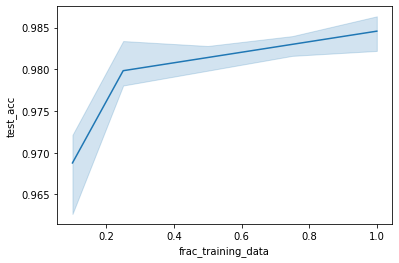

In [48]:
sns.lineplot(data=res_df, x="frac_training_data", y="test_acc")#, hue="exp")


# Run logistic regression (original, with multiple hepatocyte clusters)

In [17]:
data = macparland_data.X
label = macparland_data.obs.unmerged_celltype

In [51]:
NREPS = 5 #10
SAMPLING_FRACS = [1.0]

ks = []
fracs = []
cs=[]
train_accs = []
test_accs = []
test_f1s = []
for k in np.arange(NREPS):
    for frac in SAMPLING_FRACS:
        ks.append(k)
        fracs.append(frac)
        print("frac {}, rep {}".format(frac, k))
        #downsample training set
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2022) #update Aug 2023: hold train/val across all runs #same train/val set split for each frac in k
        for index_train, index_val in sss.split(data, label):
            np.random.seed(k)
            index_train_small = np.random.choice(index_train, round(index_train.shape[0]*frac), replace=False)
            X_train, y_train = data[index_train_small], label[index_train_small]
            X_test, y_test = data[index_val], label[index_val]

        print("Loaded data...")

        #train on train_dataset
        
        #c=0.1 was always best (for Zheng68k), using going forward without always running tuning
        #hyperparameter tune using k-fold val on training data
        cv_results = {}
        for c in [10, 100, 1000, 10000]:
            print("c={}".format(c))
            lr = LogisticRegression(random_state=0, penalty="l1", C=c, solver="liblinear")
            res = cross_validate(lr, X_train, y_train, scoring=['accuracy'])
            cv_results[c] = np.mean(res['test_accuracy'])
        print(cv_results)

        #choose best c and calc performance on val_dataset
        best_ind = np.argmax(list(cv_results.values()))
        c = list(cv_results.keys())[best_ind]
        cs.append(c)
        
        #c = 0.1
        print("best c={}".format(c))
        lr = LogisticRegression(penalty="l1", C=c, solver="liblinear") #random_state=0, 
        lr.fit(X_train, y_train)
        train_acc = lr.score(X_train, y_train)
        test_acc = lr.score(X_test, y_test)
        print("train set accuracy: " + str(np.around(train_acc, 4)))
        print("test set accuracy: " + str(np.around(test_acc, 4)))
        val_macro_f1 = f1_score(y_test, lr.predict(X_test), average="macro")
        print("test set macro F1: " + str(np.around(val_macro_f1, 4)))
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        test_f1s.append(val_macro_f1)
        
        print("\n")
        


frac 1.0, rep 0
Loaded data...
c=10
c=100
c=1000
c=10000
{10: 0.9368605551437279, 100: 0.9404179776514839, 1000: 0.9352299371276391, 10000: 0.9164078741454575}
best c=100
train set accuracy: 1.0
test set accuracy: 0.9425
test set macro F1: 0.9394


frac 1.0, rep 1
Loaded data...
c=10
c=100
c=1000
c=10000
{10: 0.936119155478681, 100: 0.9371578398264833, 1000: 0.9318225297202318, 10000: 0.9181879581583064}
best c=100
train set accuracy: 1.0
test set accuracy: 0.9443
test set macro F1: 0.944


frac 1.0, rep 2
Loaded data...
c=10
c=100
c=1000
c=10000
{10: 0.9362699393240534, 100: 0.9389375943771793, 1000: 0.9341935590149081, 10000: 0.9170009060209209}
best c=100
train set accuracy: 1.0
test set accuracy: 0.9425
test set macro F1: 0.9418


frac 1.0, rep 3
Loaded data...
c=10
c=100
c=1000
c=10000
{10: 0.9390836559316915, 100: 0.9390829970073854, 1000: 0.9324142437470829, 10000: 0.9183333607885127}
best c=10
train set accuracy: 1.0
test set accuracy: 0.9478
test set macro F1: 0.9501


frac 1.

In [52]:
#check accuracy per tissue class
for ct in np.unique(macparland_data.obs.celltype):
    print(ct+": {}".format(lr.score(X_test[y_test==ct], y_test[y_test==ct])))

Central_venous_LSECs: 0.9672131147540983
Cholangiocytes: 0.9583333333333334
Erythroid_Cells: 1.0
Hepatic_Stellate_Cells: 0.7142857142857143
Hepatocyte_1: 0.8606965174129353
Hepatocyte_2: 0.9230769230769231
Hepatocyte_3: 1.0
Hepatocyte_4: 0.859504132231405
Hepatocyte_5: 1.0
Hepatocyte_6: 0.7666666666666667
Inflammatory_Macrophage: 0.9877300613496932
Mature_B_Cells: 1.0
NK-like_Cells: 0.9693877551020408
Non-inflammatory_Macrophage: 0.9342105263157895
Periportal_LSECs: 0.9538461538461539
Plasma_Cells: 0.9901960784313726
Portal_endothelial_Cells: 1.0
alpha-beta_T_Cells: 0.9895833333333334
gamma-delta_T_Cells_1: 0.946236559139785
gamma-delta_T_Cells_2: 0.8571428571428571
